In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.size'] = 18
plt.rcParams['ytick.major.size'] = 18
plt.rc('legend', fontsize=20)
import seaborn as sns
import pandas as pd

/Users/jones289/anaconda3/envs/active_learning/lib/python3.6/site-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/Users/jones289/anaconda3/envs/active_learning/lib/python3.6/site-packages/seaborn/relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/jones289/anaconda3/envs/active_learning/lib/python

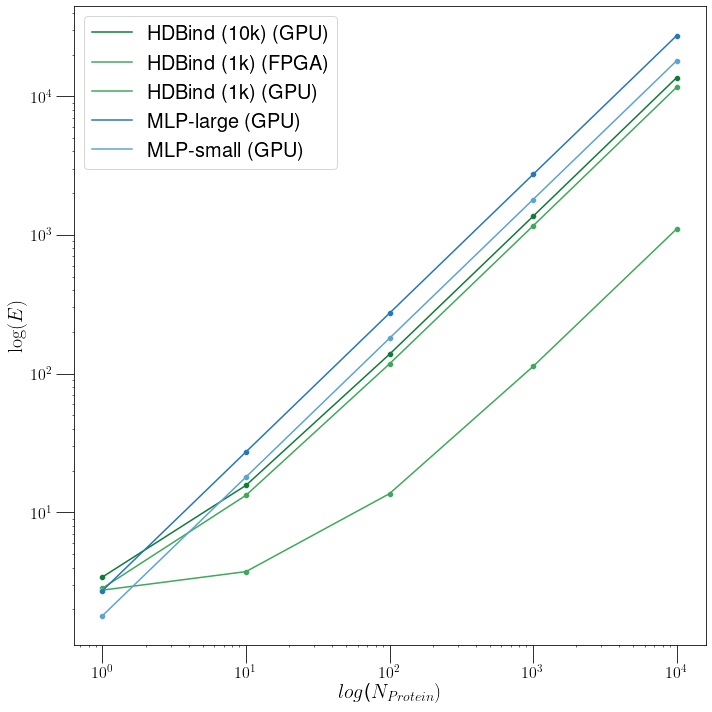

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
# rocket_color_pal = sns.color_palette("rocket", 10)



color_dict = {"HDBind (10k) (GPU)": green_color_pal[8],
              "HDBind (1k) (GPU)": green_color_pal[6],
              "HDBind (1k) (FPGA)": green_color_pal[6],
              "MLP-small (GPU)": blue_color_pal[5],
              "MLP-large (GPU)": blue_color_pal[7]}




def main():
    df = pd.read_csv("energy.csv")

    # import pdb
    # pdb.set_trace()

    col_list = ["1", "10", "100", "1000", "10000"]
    f, ax = plt.subplots(1,1, figsize=(10,10))
    # ax.set_xscale("log")
    # f.clf()

    for model, model_df in df.groupby("Model"):
        x = [int(x) for x in col_list]
        y = model_df[col_list].values.reshape(-1)

        # import pdb
        # pdb.set_trace()

        # label = f"{model} ({model_df['Device'].values.tolist()[0]})"
        label = model
        sns.lineplot(x=x, y=y, label=label, ax=ax, markers="x", c=color_dict[model])
        sns.scatterplot(x=x, y=y, ax=ax, c=color_dict[model])
        # sns.scatterplot(x=x, y=y,ax=ax, markers=False)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("$\log(E)$")
    ax.set_xlabel("$log$($N_{Protein})$")

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    plt.tight_layout()
    plt.savefig("hdbind_energy.png", dpi=450)
main()